# Extensions to Linear Models - Lab done by `Eugene Maina`

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to regularization!

## Summary

You will be able to:

- Build a linear regression model with interactions and polynomial features 
- Use feature selection to obtain the optimal subset of features in a dataset

## Let's Get Started!

Below we import all the necessary packages for this lab.

In [1]:
# Run this cell without changes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

Load the data.

In [2]:
# Run this cell without changes

# Load data from CSV
df = pd.read_csv("ames.csv")
# Subset columns
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

# Split the data into X and y
y = df['SalePrice']
X = df.drop(columns='SalePrice')

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

## Build a Baseline Housing Data Model

Above, we imported the Ames housing data and grabbed a subset of the data to use in this analysis.

Next steps:

- Scale all the predictors using `StandardScaler`, then convert these scaled features back into DataFrame objects
- Build a baseline `LinearRegression` model using *scaled variables* as predictors and use the $R^2$ score to evaluate the model 

In [3]:
# Your code here

# Scale X_train and X_val using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train,y_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Ensure X_train and X_val are scaled DataFrames
# (hint: you can set the columns using X.columns)
X_train_transformed = pd.DataFrame(scaler.transform(X_train.iloc[:]), 
                                   columns=X_train.columns[:], 
                                   index=X_train.index)
X_val_transformed = pd.DataFrame(scaler.transform(X_val.iloc[:]), 
                                  columns=X_train.columns[:], 
                                  index=X_val.index)

In [4]:
# Your code here

# Create a LinearRegression model and fit it on scaled training data
# Creating a function to run various models
def run_model(model, X_train, X_val, y_train, y_val, display=True):
    
    train_r2 = model.score(X_train, y_train)
    y_pred_train = model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    
    val_r2 = model.score(X_val, y_val)
    y_pred_val = model.predict(X_val)
    val_rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    
    if (display):
        print('Training R^2:', train_r2)
        print('Training Root Mean Squared Error:', train_rmse)
        print('\n----------------\n')
        print('Testing R^2:', val_r2)
        print('Testing Root Mean Squared Error:', val_rmse)
        
    return val_r2, val_rmse

#Calculate the linear regression and return baseline metrics.
linereg = LinearRegression()
linereg.fit(X_train_transformed,y_train)

# Calculate a baseline r-squared score on training data
baseline_r2, baseline_rmse  = run_model(linereg,X_train_transformed,X_val_transformed,y_train,y_val)


Training R^2: 0.7868344817421309
Training Root Mean Squared Error: 35419.34304614549

----------------

Testing R^2: 0.6375622643038102
Testing Root Mean Squared Error: 48979.315758524244


## Add Interactions

Instead of adding all possible interaction terms, let's try a custom technique. We are only going to add the interaction terms that increase the $R^2$ score as much as possible. Specifically we are going to look for the 7 interaction terms that each cause the most increase in the coefficient of determination.

### Find the Best Interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Create a data structure that stores the pair of columns used as well as the $R^2$ score for each combination.

***Hint:*** We have imported the `combinations` function from `itertools` for you ([documentation here](https://docs.python.org/3/library/itertools.html#itertools.combinations)). Try applying this to the columns of `X_train` to find all of the possible pairs.

Print the 7 interactions that result in the highest $R^2$ scores.

In [5]:
# Your code here

# Set up data structure
better_rscores = []

# Only consider pairwise interactions
for comb in combinations(X_train_transformed.columns, 2):
    # Make copies of X_train and X_val
    X_train_copy = X_train_transformed.copy()
    X_val_copy = X_val_transformed.copy()
    
    # Add interaction term to data
    col_name = f"{comb[0]}_{comb[1]}"
    X_train_copy[col_name] = X_train_copy[comb[0]] * X_train_copy[comb[1]]
    X_val_copy[col_name] = X_val_copy[comb[0]] * X_val_copy[comb[1]]
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train_copy, y_train)
    r2, rmse = run_model(model, X_train_copy, X_val_copy, y_train, y_val, display=False)
    
    # Append to data structure
    better_rscores.append({'r2': r2, 'rmse': rmse, 'features': comb})

# Convert to DataFrame and get top 7
better_rscores = pd.DataFrame(better_rscores)
better_rscores = better_rscores.sort_values(by='r2', ascending=False).head(7)
print(better_rscores)

          r2          rmse                    features
3   0.721111  42964.725302         (LotArea, 1stFlrSF)
2   0.707165  44025.830754      (LotArea, TotalBsmtSF)
5   0.669098  46799.978273        (LotArea, GrLivArea)
8   0.652970  47926.923281       (LotArea, Fireplaces)
36  0.647299  48316.899066    (2ndFlrSF, TotRmsAbvGrd)
17  0.642902  48617.175679  (OverallCond, TotalBsmtSF)
12  0.642232  48662.732917     (OverallQual, 2ndFlrSF)


### Add the Best Interactions

Write code to include the 7 most important interactions in `X_train` and `X_val` by adding 7 columns. Use the naming convention `"col1_col2"`, where `col1` and `col2` are the two columns in the interaction.

In [6]:
# Add the 7 best interaction terms to X_train and X_val

for _, row in better_rscores.iterrows():
    col1, col2 = row['features']
    col_name = f"{col1}_{col2}"
    X_train_transformed[col_name] = X_train_transformed[col1] * X_train_transformed[col2]
    X_val_transformed[col_name] = X_val_transformed[col1] * X_val_transformed[col2]

X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 518 to 521
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LotArea                  821 non-null    float64
 1   OverallQual              821 non-null    float64
 2   OverallCond              821 non-null    float64
 3   TotalBsmtSF              821 non-null    float64
 4   1stFlrSF                 821 non-null    float64
 5   2ndFlrSF                 821 non-null    float64
 6   GrLivArea                821 non-null    float64
 7   TotRmsAbvGrd             821 non-null    float64
 8   GarageArea               821 non-null    float64
 9   Fireplaces               821 non-null    float64
 10  LotArea_1stFlrSF         821 non-null    float64
 11  LotArea_TotalBsmtSF      821 non-null    float64
 12  LotArea_GrLivArea        821 non-null    float64
 13  LotArea_Fireplaces       821 non-null    float64
 14  2ndFlrSF_TotRmsAbvGrd   

## Add Polynomials

Now let's repeat that process for adding polynomial terms.

### Find the Best Polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of degree 4 with `PolynomialFeatures`, the particular column is raised to the power of 2 and 3 as well in other terms.

We only want to include "pure" polynomials, so make sure no interactions are included.

Once again you should make a data structure that contains the values you have tested. We recommend a list of tuples of the form:

`(col_name, degree, R2)`, so eg. `('OverallQual', 2, 0.781)` 

In [7]:
# Set up data structure
poly_scores = []

# Only use the columns that are in the original X_train_transformed (not the interaction terms)
base_columns = [col for col in X_train_transformed.columns if '_' not in col]

for col in base_columns:
    for degree in [2, 3, 4]:
        # Make a copy of X_train_transformed and X_val_transformed
        X_train_poly = X_train_transformed.copy()
        X_val_poly = X_val_transformed.copy()
        
        # Instantiate PolynomialFeatures with relevant degree (no interaction_only)
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        
        # Fit and transform only the single column
        train_col = X_train_poly[[col]]
        val_col = X_val_poly[[col]]
        poly_train = poly.fit_transform(train_col)
        poly_val = poly.transform(val_col)
        
        # Get feature names (skip the first one, which is the original column)
        feature_names = poly.get_feature_names_out([col])
        
        # Only keep the pure polynomial terms (degree > 1)
        for i in range(1, degree):
            poly_col_name = f"{col}^{i+1}"
            # Add polynomial column to the data
            X_train_poly[poly_col_name] = poly_train[:, i+0]
            X_val_poly[poly_col_name] = poly_val[:, i+0]
            
            # Fit linear regression
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
            r2, rmse = run_model(model, X_train_poly, X_val_poly, y_train, y_val, display=False)
            
            # Append to data structure
            poly_scores.append((col, i+1, r2))

            # Remove the column for next iteration
            X_train_poly.drop(columns=[poly_col_name], inplace=True)
            X_val_poly.drop(columns=[poly_col_name], inplace=True)

# Convert to DataFrame and get top 7
poly_scores_df = pd.DataFrame(poly_scores, columns=['col_name', 'degree', 'r2'])
poly_scores_df = poly_scores_df.sort_values(by='r2', ascending=False).head(7)
print(poly_scores_df)


       col_name  degree        r2
41    GrLivArea       4  0.823410
23  TotalBsmtSF       4  0.821819
6   OverallQual       2  0.802583
7   OverallQual       2  0.802583
9   OverallQual       2  0.802583
38    GrLivArea       3  0.794202
40    GrLivArea       3  0.794202


### Add the Best Polynomials

If there are duplicate column values in the results above, don't add multiple of them to the model, to avoid creating duplicate columns. (For example, if column `A` appeared in your list as both a 2nd and 3rd degree polynomial, adding both would result in `A` squared being added to the features twice.) Just add in the polynomial that results in the highest R-Squared.

In [8]:

    
# Add polynomial columns to the data
# Keep track of which columns have already had a polynomial added
added_cols = set()

for _, row in poly_scores_df.iterrows():
    col_name = row['col_name']
    degree = row['degree']
    if col_name in added_cols:
        continue  # Skip if we've already added a polynomial for this column
    added_cols.add(col_name)
    
    # Instantiate PolynomialFeatures with relevant degree (no interaction_only)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Fit and transform only the single column
    train_col = X_train_transformed[[col_name]]
    val_col = X_val_transformed[[col_name]]
    poly_train = poly.fit_transform(train_col)
    poly_val = poly.transform(val_col)
    
    # Get feature names (skip the first one, which is the original column)
    feature_names = poly.get_feature_names_out([col_name])[1:]
    
    # Add polynomial columns to the data (start from degree 2)
    for i, name in enumerate(feature_names, start=1):
        poly_col_name = f"{col_name}^{i+1}"
        X_train_poly[poly_col_name] = poly_train[:, i]
        X_val_poly[poly_col_name] = poly_val[:, i]


Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [9]:
# Your code here
X_train_poly.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,...,2ndFlrSF_TotRmsAbvGrd,OverallCond_TotalBsmtSF,OverallQual_2ndFlrSF,GrLivArea^2,GrLivArea^3,GrLivArea^4,TotalBsmtSF^2,TotalBsmtSF^3,TotalBsmtSF^4,OverallQual^2
518,-0.114710,-0.099842,-0.509252,-0.639316,-0.804789,1.261552,0.499114,0.250689,0.327629,-0.994820,...,0.316257,0.325573,-0.125956,0.249115,0.124337,0.062058,0.408725,-0.261304,1.670559e-01,0.009968
236,-0.176719,0.632038,-0.509252,0.838208,0.641608,-0.808132,-0.247249,-0.365525,0.079146,-0.994820,...,0.295392,-0.426859,-0.510770,0.061132,-0.015115,0.003737,0.702592,0.588918,4.936357e-01,0.399472
38,-0.246336,-0.831723,1.304613,-0.012560,-0.329000,-0.808132,-0.944766,-0.981739,-1.105931,-0.994820,...,0.793375,-0.016386,0.672141,0.892583,-0.843282,0.796704,0.000158,-0.000002,2.488547e-08,0.691762
1034,-0.378617,-0.831723,1.304613,-0.339045,-0.609036,-0.808132,-1.146010,-0.981739,-1.134602,0.588023,...,0.793375,-0.442323,0.672141,1.313340,-1.505101,1.724862,0.114951,-0.038974,1.321384e-02,0.691762
520,-0.010898,-1.563603,1.304613,-2.531499,-1.315922,0.550523,-0.481708,0.250689,-2.281450,-0.994820,...,0.138010,-3.302627,-0.860799,0.232043,-0.111777,0.053844,6.408489,-16.223084,4.106873e+01,2.444854


## Full Model R-Squared

Check out the $R^2$ of the full model with your interaction and polynomial terms added. Print this value for both the train and validation data.

In [10]:
# Your code here
poly_line_reg = LinearRegression()
poly_line_reg.fit(X_train_poly, y_train)

poly_r2, poly_rmse = run_model(poly_line_reg, X_train_poly, X_val_poly, y_train, y_val)

Training R^2: 0.8496228852784854
Training Root Mean Squared Error: 29749.036078779034

----------------

Testing R^2: -53.64121957451681
Testing Root Mean Squared Error: 601389.998904917


It looks like we may be overfitting some now. Let's try some feature selection techniques.

## Feature Selection

First, test out `RFE` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)) with several different `n_features_to_select` values. For each value, print out the train and validation $R^2$ score and how many features remain.

In [11]:
# Your code here
n_values = np.arange(1, len(X_train_poly.columns), 3)
reduced_r2 = []
for n in n_values:

    rfe = RFE(LinearRegression(), n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train_poly,y_train)
    X_val_rfe = rfe.transform(X_val_poly)

    rfe_reg = LinearRegression()
    rfe_reg.fit(X_train_rfe, y_train)

    rfe_reg_r2, rfe_reg_mse = run_model(rfe_reg, X_train_rfe, X_val_rfe, y_train, y_val)
    reduced_r2.append(rfe_reg_r2)

    print('\n----------------\n')
    print(f"{X_train_rfe.shape[1]} out of {X_train_poly.shape[1]} features used")
    print('Baseline Polynomial R-Squared:', round(poly_r2, 2))
    print('Reduced R-Squared: ', round(rfe_reg_r2, 3))
    print('\n--------------------------------------------------------\n')



Training R^2: 0.626356624409971
Training Root Mean Squared Error: 46893.286152833505

----------------

Testing R^2: 0.5883499799376483
Testing Root Mean Squared Error: 52198.74721462057

----------------

1 out of 24 features used
Baseline Polynomial R-Squared: -53.64
Reduced R-Squared:  0.588

--------------------------------------------------------

Training R^2: 0.7613382811926305
Training Root Mean Squared Error: 37477.74108116232

----------------

Testing R^2: 0.6145675279067213
Testing Root Mean Squared Error: 50509.161599366096

----------------

4 out of 24 features used
Baseline Polynomial R-Squared: -53.64
Reduced R-Squared:  0.615

--------------------------------------------------------

Training R^2: 0.8115194451646931
Training Root Mean Squared Error: 33305.449567066666

----------------

Testing R^2: 0.6487149078250316
Testing Root Mean Squared Error: 48219.851578587

----------------

7 out of 24 features used
Baseline Polynomial R-Squared: -53.64
Reduced R-Squared:  

Now test out `Lasso` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)) with several different `alpha` values.

In [12]:
# Your code here
alpha_values = np.linspace(1, 10, 5)

for value in alpha_values:
    
    lasso_rfe = RFE(Lasso(), n_features_to_select=13)
    X_train_lasso =lasso_rfe.fit_transform(X_train_poly, y_train)
    X_val_lasso = lasso_rfe.transform(X_val_poly)

    lasso = Lasso(alpha=value)
    lasso.fit(X_train_lasso, y_train)

    
    print(f"Alpha: {value:.2f}")
    lasso_r2, lasso_mse = run_model(lasso, X_train_lasso, X_val_lasso, y_train, y_val)
    print('\n********************************\n')
    print('Baseline R-Squared:', round(baseline_r2, 4))
    print('Reduced R-Squared: ', round(lasso_r2, 4))
    print('\n--------------------------------------------------------\n')

    
    
   



Alpha: 1.00
Training R^2: 0.8269122638498954
Training Root Mean Squared Error: 31916.4936286767

----------------

Testing R^2: 0.8045860734881961
Testing Root Mean Squared Error: 35964.4783228538

********************************

Baseline R-Squared: 0.6376
Reduced R-Squared:  0.8046

--------------------------------------------------------

Alpha: 3.25
Training R^2: 0.8269122025509044
Training Root Mean Squared Error: 31916.49928028648

----------------

Testing R^2: 0.8044699061074858
Testing Root Mean Squared Error: 35975.16660540685

********************************

Baseline R-Squared: 0.6376
Reduced R-Squared:  0.8045

--------------------------------------------------------

Alpha: 5.50
Training R^2: 0.8269120762665084
Training Root Mean Squared Error: 31916.510923380778

----------------

Testing R^2: 0.8043529752075298
Testing Root Mean Squared Error: 35985.92193161395

********************************

Baseline R-Squared: 0.6376
Reduced R-Squared:  0.8044

------------------

Compare the results. Which features would you choose to use?

In [13]:
# Your written answer here

print(f'From the RFE analysis, the optimal number of features to select would be 13 out of 24 features obtained after transforming the baseline data.\nThe R^2 at this point for both training and testing is at 80.5% and the MSE bor both are below the basline model.\nThe model is also neither overfitting or underfitting. ')

From the RFE analysis, the optimal number of features to select would be 13 out of 24 features obtained after transforming the baseline data.
The R^2 at this point for both training and testing is at 80.5% and the MSE bor both are below the basline model.
The model is also neither overfitting or underfitting. 


## Evaluate Final Model on Test Data

### Data Preparation

At the start of this lab, we created `X_test` and `y_test`. Prepare `X_test` the same way that `X_train` and `X_val` have been prepared. This includes scaling, adding interactions, and adding polynomial terms.

In [14]:
# Your code here
# Transforming the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Scale X_test using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train,y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_transformed = pd.DataFrame(scaler.transform(X_train.iloc[:]), 
                                  columns=X_train.columns[:], 
                                  index=X_train.index)


X_test_transformed = pd.DataFrame(scaler.transform(X_test.iloc[:]), 
                                  columns=X_train.columns[:], 
                                  index=X_test.index)

#Determining and adding Interactions.
# Set up data structure
better_rscores = []

# Only consider pairwise interactions
for comb in combinations(X_train_transformed.columns, 2):
    # Make copies of X_train and X_val
    X_train_copy = X_train_transformed.copy()
    X_test_copy = X_test_transformed.copy()
    
    # Add interaction term to data
    col_name = f"{comb[0]}_{comb[1]}"
    X_train_copy[col_name] = X_train_copy[comb[0]] * X_train_copy[comb[1]]
    X_test_copy[col_name] = X_test_copy[comb[0]] * X_test_copy[comb[1]]
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train_copy, y_train)
    r2, rmse = run_model(model, X_train_copy, X_test_copy, y_train, y_test, display=False)
    
    # Append to data structure
    better_rscores.append({'r2': r2, 'rmse': rmse, 'features': comb})

# Convert to DataFrame and get top 7
better_rscores = pd.DataFrame(better_rscores)
better_rscores = better_rscores.sort_values(by='r2', ascending=False).head(7)

# Add the 7 best interaction terms to X_train and X_val

for _, row in better_rscores.iterrows():
    col1, col2 = row['features']
    col_name = f"{col1}_{col2}"
    X_train_transformed[col_name] = X_train_transformed[col1] * X_train_transformed[col2]
    X_test_transformed[col_name] = X_test_transformed[col1] * X_test_transformed[col2]
  


In [15]:
#Adding the Polynomials
# Set up data structure
poly_scores = []

# Only use the columns that are in the original X_train_transformed (not the interaction terms)
base_columns = [col for col in X_train_transformed.columns if '_' not in col]

for col in base_columns:
    for degree in [2, 3, 4]:
        # Make a copy of X_train_transformed and X_test_transformed
        X_train_poly = X_train_transformed.copy()
        X_test_poly = X_test_transformed.copy()
        
        # Instantiate PolynomialFeatures with relevant degree (no interaction_only)
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        
        # Fit and transform only the single column
        train_col = X_train_poly[[col]]
        test_col = X_test_poly[[col]]
        poly_train = poly.fit_transform(train_col)
        poly_test = poly.transform(test_col)
        
        # Get feature names (skip the first one, which is the original column)
        feature_names = poly.get_feature_names_out([col])
        
        # Only keep the pure polynomial terms (degree > 1)
        for i in range(1, degree):
            poly_col_name = f"{col}^{i+1}"
            # Add polynomial column to the data
            X_train_poly[poly_col_name] = poly_train[:, i+0]
            X_test_poly[poly_col_name] = poly_test[:, i+0]
            
            # Fit linear regression
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
            r2, rmse = run_model(model, X_train_poly, X_test_poly, y_train, y_test, display=False)
            
            # Append to data structure
            poly_scores.append((col, i+1, r2))

            # Remove the column for next iteration
            X_train_poly.drop(columns=[poly_col_name], inplace=True)
            X_test_poly.drop(columns=[poly_col_name], inplace=True)

# Convert to DataFrame and get top 7
poly_scores_df = pd.DataFrame(poly_scores, columns=['col_name', 'degree', 'r2'])
poly_scores_df = poly_scores_df.sort_values(by='r2', ascending=False).head(7)

# Add polynomial columns to the data
# Keep track of which columns have already had a polynomial added
added_cols = set()

for _, row in poly_scores_df.iterrows():
    col_name = row['col_name']
    degree = row['degree']
    if col_name in added_cols:
        continue  # Skip if we've already added a polynomial for this column
    added_cols.add(col_name)
    
    # Instantiate PolynomialFeatures with relevant degree (no interaction_only)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Fit and transform only the single column
    train_col = X_train_transformed[[col_name]]
    test_col = X_test_transformed[[col_name]]
    poly_train = poly.fit_transform(train_col)
    poly_test = poly.transform(test_col)
    
    # Get feature names (skip the first one, which is the original column)
    feature_names = poly.get_feature_names_out([col_name])[1:]
    
    # Add polynomial columns to the data (start from degree 2)
    for i, name in enumerate(feature_names, start=1):
        poly_col_name = f"{col_name}^{i+1}"
        X_train_poly[poly_col_name] = poly_train[:, i]
        X_test_poly[poly_col_name] = poly_test[:, i]


X_train_poly.head()



,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,...,OverallQual_1stFlrSF,2ndFlrSF_GrLivArea,1stFlrSF^2,1stFlrSF^3,1stFlrSF^4,TotalBsmtSF^2,TotalBsmtSF^3,GrLivArea^2,GrLivArea^3,GrLivArea^4
1023,-0.683950,0.637073,-0.515364,0.642893,0.862092,-0.805280,-0.051643,0.268177,-0.192617,0.591298,...,0.549216,0.041587,0.743203,0.640710,0.552351,0.413311,0.265715,0.002667,-0.000138,0.000007
810,-0.054883,-0.094926,0.390453,-0.046799,0.357895,-0.805280,-0.421692,-0.963076,0.030695,0.591298,...,-0.033974,0.339580,0.128089,0.045843,0.016407,0.002190,-0.000102,0.177824,-0.074987,0.031621
1384,-0.152524,-0.094926,-0.515364,-1.128667,-1.221922,0.465855,-0.518474,-0.347450,-0.938576,-0.961392,...,0.115992,-0.241534,1.493093,-1.824443,2.229326,1.273890,-1.437798,0.268816,-0.139374,0.072262
626,0.144198,-0.826925,-0.515364,-0.186540,0.650071,-0.805280,-0.207253,-0.347450,-0.910068,0.591298,...,-0.537560,0.166897,0.422592,0.274715,0.178584,0.034797,-0.006491,0.042954,-0.008902,0.001845
813,-0.090142,-0.094926,0.390453,0.859266,0.701784,-0.805280,-0.169300,0.268177,-0.838798,-0.961392,...,-0.066617,0.136334,0.492500,0.345629,0.242557,0.738339,0.634430,0.028662,-0.004853,0.000822


### Evaluation

Using either `RFE` or `Lasso`, fit a model on the complete train + validation set, then find R-Squared and MSE values for the test set.

In [16]:
# Your code here
from sklearn.feature_selection import RFECV


rfe_cv = RFECV(LinearRegression(), cv=15)
X_rfe_train = rfe_cv.fit_transform(X_train_poly, y_train)
X_rfe_test = rfe_cv.transform(X_test_poly)
lr = LinearRegression()
lr.fit(X_rfe_train, y_train)

rfe_r2, rfe_rmse = run_model(lr, X_rfe_train, X_rfe_test, y_train, y_test)
print('\n----------------\n')
print(f"{X_rfe_train.shape[1]} out of {X_train_poly.shape[1]} features used")
print('Baseline R-Squared:', round(poly_r2, 3))
print('Reduced R-Squared: ', round(rfe_r2, 3))

Training R^2: 0.8363721647081331
Training Root Mean Squared Error: 31519.15963061897

----------------

Testing R^2: 0.8473441981043901
Testing Root Mean Squared Error: 32701.698287878473

----------------

10 out of 25 features used
Baseline R-Squared: -53.641
Reduced R-Squared:  0.847


## Level Up Ideas (Optional)

### Create a Lasso Path

From this section, you know that when using `Lasso`, more parameters shrink to zero as your regularization parameter goes up. In scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for Subset Selection

This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Ames housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

### Lasso Path

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the LARS...
Computing regularization path using the positive LARS...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


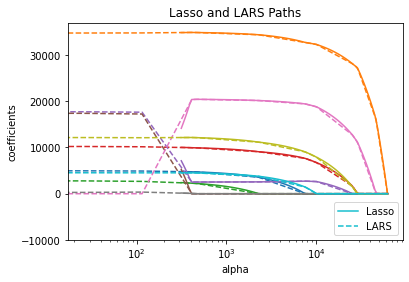

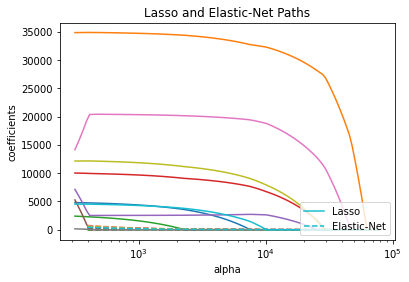

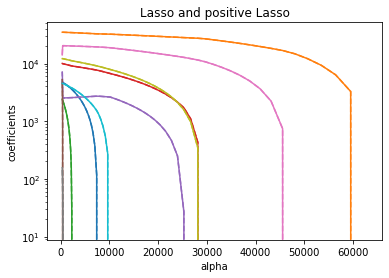

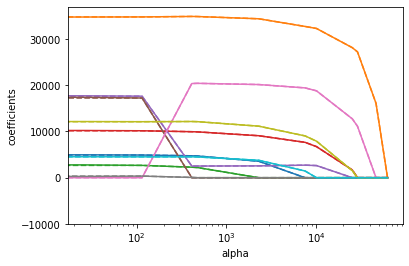

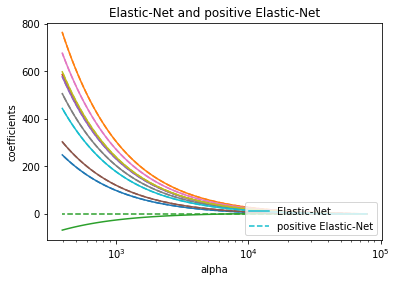

In [17]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from itertools import cycle

import matplotlib.pyplot as plt


from sklearn.linear_model import enet_path, lars_path, lasso_path

# Assumes df is already defined in a previous cell
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

# Define X and y
X = df.drop(columns="SalePrice").values
y = df["SalePrice"].values

# Standardize data (easier to set the l1_ratio parameter)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps=eps, positive=True
)

print("Computing regularization path using the LARS...")
alphas_lars, _, coefs_lars = lars_path(X, y, method="lasso")

print("Computing regularization path using the positive LARS...")
alphas_positive_lars, _, coefs_positive_lars = lars_path(
    X, y, method="lasso", positive=True
)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True
)

# Display results

plt.figure(1)
# Use a color cycle with enough colors for all features
# Ensure coefficient arrays are (n_features, n_alphas)
if coefs_lasso.shape[0] != X.shape[1]:
    coefs_lasso = coefs_lasso.T
if coefs_lars.shape[0] != X.shape[1]:
    coefs_lars = coefs_lars.T
if coefs_enet.shape[0] != X.shape[1]:
    coefs_enet = coefs_enet.T
if coefs_positive_lasso.shape[0] != X.shape[1]:
    coefs_positive_lasso = coefs_positive_lasso.T
if coefs_positive_lars.shape[0] != X.shape[1]:
    coefs_positive_lars = coefs_positive_lars.T
if coefs_positive_enet.shape[0] != X.shape[1]:
    coefs_positive_enet = coefs_positive_enet.T

num_features = coefs_lasso.shape[0]
color_list = plt.cm.tab10.colors if num_features <= 10 else plt.cm.tab20.colors
colors = cycle(color_list)
for coef_lasso, coef_lars, c in zip(coefs_lasso, coefs_lars, colors):
    l1 = plt.semilogx(alphas_lasso, coef_lasso, c=c)
    l2 = plt.semilogx(alphas_lars, coef_lars, linestyle="--", c=c)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso and LARS Paths")
plt.legend((l1[-1], l2[-1]), ("Lasso", "LARS"), loc="lower right")

plt.figure(2)
colors = cycle(color_list)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.semilogx(alphas_lasso, coef_l, c=c)
    l2 = plt.semilogx(alphas_enet, coef_e, linestyle="--", c=c)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.legend((l1[-1], l2[-1]), ("Lasso", "Elastic-Net"), loc="lower right")

plt.figure(3)
colors = cycle(color_list)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.semilogy(alphas_lasso, coef_l, c=c)
    l2 = plt.semilogy(alphas_positive_lasso, coef_pl, linestyle="--", c=c)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso and positive Lasso")

plt.figure(4)
colors = cycle(color_list)
for coef_lars, coef_positive_lars, c in zip(coefs_lars, coefs_positive_lars, colors):
    l1 = plt.semilogx(alphas_lars, coef_lars, c=c)
    l2 = plt.semilogx(alphas_positive_lars, coef_positive_lars, linestyle="--", c=c)

plt.xlabel("alpha")
plt.ylabel("coefficients")

plt.figure(5)
colors = cycle(color_list)
for coef_e, coef_pe, c in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.semilogx(alphas_enet, coef_e, c=c)
    l2 = plt.semilogx(alphas_positive_enet, coef_pe, linestyle="--", c=c)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Elastic-Net and positive Elastic-Net")
plt.legend((l1[-1], l2[-1]), ("Elastic-Net", "positive Elastic-Net"), loc="lower right")
plt.axis("tight")
plt.show()

## Summary

Congratulations! You now know how to apply concepts of bias-variance tradeoff using extensions to linear models and feature selection.